Introduction text
https://www.analyticsvidhya.com/blog/2018/09/reinforcement-multi-armed-bandit-scratch-python/
    

In [50]:
# libraries to import
import numpy as np
import matplotlib.pyplot as plt

In [51]:
# useful functions
def show_bar_plot(x_axis, y_axis, x_label, y_label, title):

    # Create bar chart
    plt.bar(x_axis, y_axis)

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Show the plot
    plt.show()
    
def show_line_plot(x_axis, y_axis, labels, x_label, y_label, title):

    # Create line chart
    for y, l in zip(y_axis, labels):
        plt.plot(x_axis, y, label='l')
        plt.legend(labels)
        
    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Show the plot
    plt.show()

In [52]:
# Total number of arms
N_ARMS = 6

# probabilities
p = np.random.rand(N_ARMS)
highest_prob_arm = np.argmax(p)
print("The arm with the highest probability is at index : " + str(highest_prob_arm) + " \nits probability is : " + str(p[highest_prob_arm]))

initial_money = 1000000
price_per_play = 0.5
reward = 1

The arm with the highest probability is at index : 5 
its probability is : 0.7955688769551353


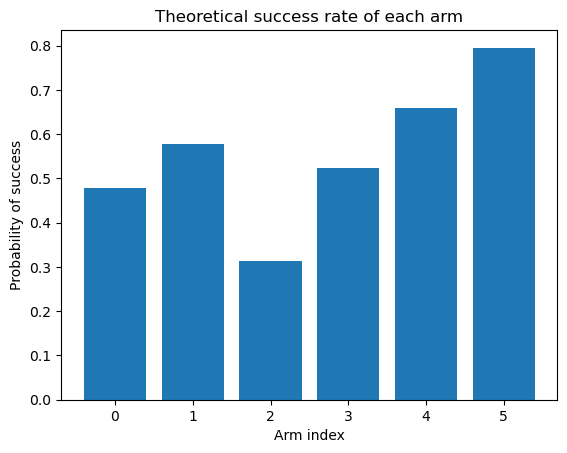

In [53]:
show_bar_plot(x_axis = range(len(p)), y_axis = p, x_label="Arm index", y_label="Probability of success", title="Theoretical success rate of each arm")

# Strategy 1 : Explore then exploit

For this, we explore by playing a 100 times each arm, then depending on which one got us the most wins, we decide to commit to it.

In [106]:
explore_per_arm = 100

results_all_arms = np.zeros((N_ARMS, explore_per_arm))
print("We have the arms in the rows, and results of explore in the columns " + str(np.shape(results_all_arms)))

for arm_index in range(N_ARMS):
    results_all_arms[arm_index, :] = np.random.choice([0, 1], size=(1, explore_per_arm), p=[1-float(p[arm_index]), float(p[arm_index])])
    

We have the arms in the rows, and results of explore in the columns (6, 100)


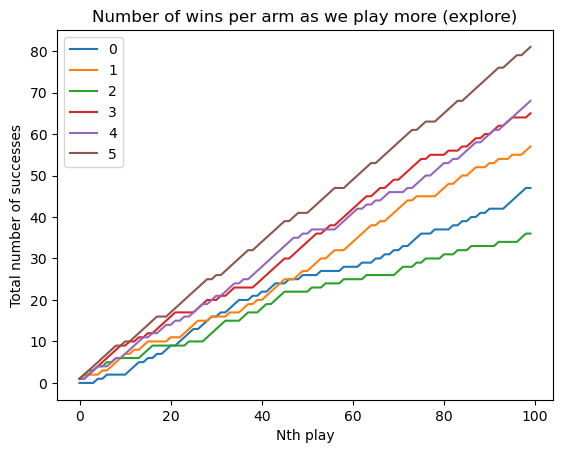

In [107]:
cum_sum_results_all_arms = np.cumsum(results_all_arms, axis=1)

show_line_plot(x_axis=range(explore_per_arm), y_axis=cum_sum_results_all_arms, labels=range(N_ARMS), x_label="Nth play", y_label="Total number of successes", title="Number of wins per arm as we play more (explore)")
    


In [108]:
end_of_explore_results = np.sum(results_all_arms, axis=1)
end_of_explore_results

array([47., 57., 36., 65., 68., 81.])

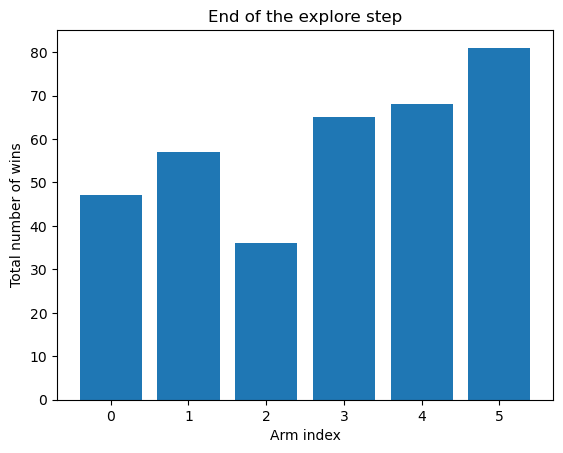

In [109]:
show_bar_plot(x_axis = range(len(end_of_explore_results)), y_axis = end_of_explore_results, x_label="Arm index", y_label="Total number of wins", title="End of the explore step")

In [110]:
index_with_most_wins = np.argmax(end_of_explore_results)
print("The arm that won the most is : " + str(index_with_most_wins) + " with " + str(int(end_of_explore_results[index_with_most_wins])) + " wins.")

The arm that won the most is : 5 with 81 wins.


In [111]:
money_invested = explore_per_arm * N_ARMS * price_per_play
money_gained = np.sum(end_of_explore_results, axis=0)
money_diff_end_of_explore = money_gained - money_invested
money_left_end_of_explore = initial_money + money_diff_end_of_explore
print("Money invested : " + str(money_invested))
print("Money gained : " + str(money_gained))
print("Money difference at the end of explore round : " + str(money_diff_end_of_explore))
print("Money left at the end of explore round : " + str(money_left_end_of_explore))


Money invested : 300.0
Money gained : 354.0
Money difference at the end of explore round : 54.0
Money left at the end of explore round : 1000054.0


## Commit phase
Hopefully, after the explore phase, we got the correct index that has the highest probability and now we can start winning in the long run.

# Strategy 2 : Explore then exploit - by elimination

In the previous strategy, we say decide initially how much we are going to play. To reduce the cost of exploring, we can enhance this strategy by eliminating the worst arm after a given number of plays so that we can avoid wasting money on the worst performing arm.

In [121]:
explore_per_arm = 30
n_rounds = 5

# check that n_rounds < N_ARMS
if n_rounds >= N_ARMS:
    raise Exception("Number of rounds should be strictly lesser than the number of arms")

end_of_explore_results = np.zeros((N_ARMS, 1))
poor_performing_arms = []

results_all_arms_all_rounds = np.zeros((N_ARMS, 1))
    
for i in range(n_rounds):
    
    results_all_arms = np.zeros((N_ARMS, explore_per_arm))
    
    for arm_index in range(N_ARMS):
        # doesn't exist in the poor performing list
        if poor_performing_arms.count(arm_index) == 0:
            results_all_arms[arm_index, :] = np.random.choice([0, 1], size=(1, explore_per_arm), p=[1-float(p[arm_index]), float(p[arm_index])])
            
    end_of_round_results = np.sum(results_all_arms, axis=1).reshape((N_ARMS,1))
    end_of_explore_results = end_of_explore_results + end_of_round_results
    
    index_with_least_wins = np.argsort(end_of_explore_results, axis=0)[i]
    
    print("Round " + str(i) + ", The arm that won the least is : " + str(index_with_least_wins) + " with " + str(int(end_of_explore_results[index_with_least_wins])) + " wins.")
    poor_performing_arms.append(index_with_least_wins)
    
    results_all_arms_all_rounds = np.concatenate((results_all_arms_all_rounds, results_all_arms), axis=1)

# reshape
results_all_arms_all_rounds = results_all_arms_all_rounds[:, 1:]

Round 0, The arm that won the least is : [0] with 9 wins.
Round 1, The arm that won the least is : [2] with 22 wins.
Round 2, The arm that won the least is : [3] with 49 wins.
Round 3, The arm that won the least is : [1] with 66 wins.
Round 4, The arm that won the least is : [4] with 108 wins.


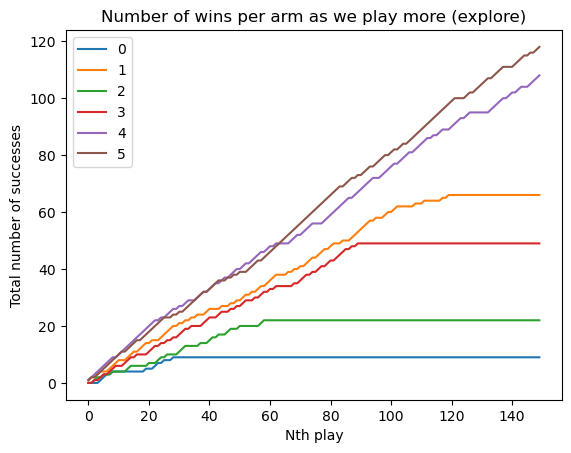

In [122]:
cum_sum_results_all_arms = np.cumsum(results_all_arms_all_rounds, axis=1)

show_line_plot(x_axis=range(explore_per_arm*n_rounds), y_axis=cum_sum_results_all_arms, labels=range(N_ARMS), x_label="Nth play", y_label="Total number of successes", title="Number of wins per arm as we play more (explore)")

In [123]:
end_of_explore_results

array([[  9.],
       [ 66.],
       [ 22.],
       [ 49.],
       [108.],
       [118.]])

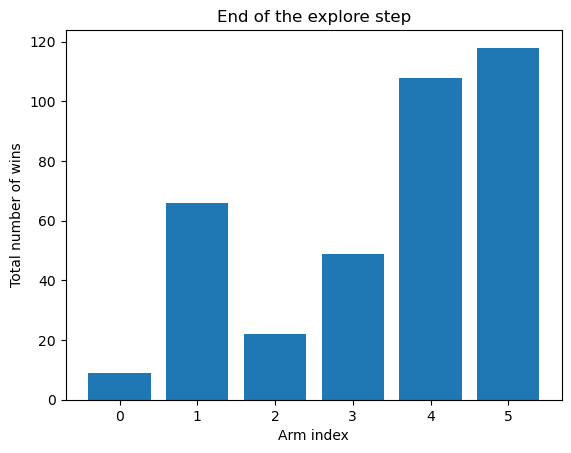

In [124]:
show_bar_plot(x_axis = range(len(end_of_explore_results.ravel())), y_axis = end_of_explore_results.ravel(), x_label="Arm index", y_label="Total number of wins", title="End of the explore step")

In [125]:
index_with_most_wins = np.argmax(end_of_explore_results)
print("The arm that won the most is : " + str(index_with_most_wins) + " with " + str(int(end_of_explore_results[index_with_most_wins])) + " wins.")

The arm that won the most is : 5 with 118 wins.


In [126]:
money_invested = 0
for i in range(n_rounds):
    money_invested = money_invested + explore_per_arm * (N_ARMS - i) * price_per_play
    
money_gained = np.sum(end_of_explore_results, axis=0)
money_diff_end_of_explore = money_gained - money_invested
money_left_end_of_explore = initial_money + money_diff_end_of_explore
print("Money invested : " + str(money_invested))
print("Money gained : " + str(money_gained))
print("Money difference at the end of explore round : " + str(money_diff_end_of_explore))
print("Money left at the end of explore round : " + str(money_left_end_of_explore))

Money invested : 300.0
Money gained : [372.]
Money difference at the end of explore round : [72.]
Money left at the end of explore round : [1000072.]


# Strategy 3 : Continuous approach

In the previous strategy, we say decide initially how much we are going to play. This can become a problem in situations where we have limited resources. 
A strategy would be to assign weights to each arm and recalculate every time we try one.